In [265]:
import matplotlib as mlt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)


## Сервисные методы

### Фабрика функций $\varphi(t) = f(x - t \cdot d)$


In [266]:
def phi_factory(func, x, d):
    return lambda t: func(x - t * d)


### Поиск минимума методом золотого сечения


In [267]:
def golden_method(func):
    right = 0
    left = 5
    eps = 0.00001
    phi = (1 + np.sqrt(5)) / 2
    resphi = 2 - phi
    x1 = left + resphi * (right - left)
    x2 = right - resphi * (right - left)
    f1 = func(x1)
    f2 = func(x2)
    while abs(right - left) > eps:
        if f1 < f2:
            right = x2
            x2 = x1
            f2 = f1
            x1 = left + resphi * (right - left)
            f1 = func(x1)
        else:
            left = x1
            x1 = x2
            f1 = f2
            x2 = right - resphi * (right - left)
            f2 = func(x2)
    return (x1 + x2) / 2


### Получение данных для построения трехмерных графиков


In [268]:
def setup_3d_data(func, num):
    x = y = np.linspace(-1.5, 1.5, num=num)
    x = np.repeat(x, num)
    y = np.tile(y, num)
    z = []
    for i in range(num**2):
        z.append(func(np.array([x[i], y[i]])))
    x = np.reshape(x, (num, num))
    y = np.reshape(y, (num, num))
    z = np.reshape(z, (num, num))
    return x, y, z


## 1. Градиентный спуск с постоянным шагом


In [269]:
def gradient_descent(func, grad, x_0, eps1, eps2, max_iter, t=0.0001):
    x = x_0
    k = 0
    df = pd.DataFrame({"x": []})
    df.index.name = "i"
    df.name = "x"
    df.loc[len(df)] = [x]
    while True:
        if np.isnan(x).any():
            return x, k, df
        grad_x = grad(x)
        if np.linalg.norm(grad_x) < eps1 or k >= max_iter:
            return x, k, df
        x_next = x - t * grad_x
        df.loc[len(df)] = [x_next]
        k += 1
        if np.linalg.norm(x_next - x) < eps2 and abs(func(x_next) - func(x)) < eps2:
            return x_next, k, df
        x = x_next


## 2. Метод спуска с дроблением шага


In [270]:
def step_splitting_descent(func, grad, x_0, eps1, eps2, max_iter, _=0):
    x = x_0
    k = 0
    e = 0.1
    t = 1
    df = pd.DataFrame({"x": []})
    df.index.name = "i"
    df.name = "x"
    df.loc[len(df)] = [x]
    while True:
        if np.isnan(x).any():
            return x, k, df
        grad_x = grad(x)
        if np.linalg.norm(grad_x) < eps1 or k >= max_iter:
            return x, k, df
        phi = phi_factory(func, x, grad_x)
        while phi(t) > func(x) + t * e * (grad_x.T @ (-grad_x)):
            t = t / 2
        x_next = x - t * grad_x
        df.loc[len(df)] = [x_next]
        k += 1
        if np.linalg.norm(x_next - x) < eps2 and abs(func(x_next) - func(x)) < eps2:
            return x_next, k, df
        x = x_next


## 3. Метод наискорейшего спуска


In [271]:
def steepest_descent(func, grad, x_0, eps1, eps2, max_iter, _=0):
    x = x_0
    k = 0
    df = pd.DataFrame({"x": []})
    df.index.name = "i"
    df.name = "x"
    df.loc[len(df)] = [x]
    while True:
        if np.isnan(x).any():
            return x, k, df
        grad_x = grad(x)
        if np.linalg.norm(grad_x) < eps1 or k >= max_iter:
            return x, k, df
        phi = phi_factory(func, x, grad_x)
        t = golden_method(phi)
        x_next = x - t * grad_x
        df.loc[len(df)] = [x_next]
        k += 1
        if np.linalg.norm(x_next - x) < eps2 and abs(func(x_next) - func(x)) < eps2:
            return x_next, k, df
        x = x_next


## 4. Метод сопряженных градиентов


In [272]:
def conjugate_gradient(func, grad, x_0, eps1, eps2, max_iter, _=0):
    x = x_prev = x_0
    k = 0
    prev_good = False
    df = pd.DataFrame({"x": []})
    df.index.name = "i"
    df.name = "x"
    df.loc[len(df)] = [x]
    while True:
        if np.isnan(x).any():
            return x, k, df
        grad_x = grad(x)
        if np.linalg.norm(grad_x) < eps1 or k >= max_iter:
            return x, k, df
        if k == 0:
            d = - grad(x_0)
        else:
            beta = (np.linalg.norm(grad_x))**2 / (np.linalg.norm(grad(x_prev)))**2
            d = -grad_x + beta * d
        phi = phi_factory(func, x, -d)
        t = golden_method(phi)
        x_next = x + t * d
        df.loc[len(df)] = [x_next]
        k += 1
        if np.linalg.norm(x_next - x) < eps2 and abs(func(x_next) - func(x)) < eps2:
            if prev_good:
                return x_next, k, df
            prev_good = True
        else:
            prev_good = False
        x_prev = x
        x = x_next


## 5. Тестируемые квадратичные функции


In [273]:
def f_1(x):
    return x @ np.array(np.mat('2 0; 1 1')) @ x.T

def f_1_grad(x):
    a = np.array(np.mat('2 0; 1 1'))
    return (a + a.T) @ x.T

In [274]:
def f_2(x):
    return x @ np.array(np.mat('3299.599043 -36.367496; -36.367496 1.400957')) @ x.T

def f_2_grad(x):
    a = np.array(np.mat('3299.599043 -36.367496; -36.367496 1.400957'))
    return (a + a.T) @ x.T


## 6. Тест

### $f_1(x)$


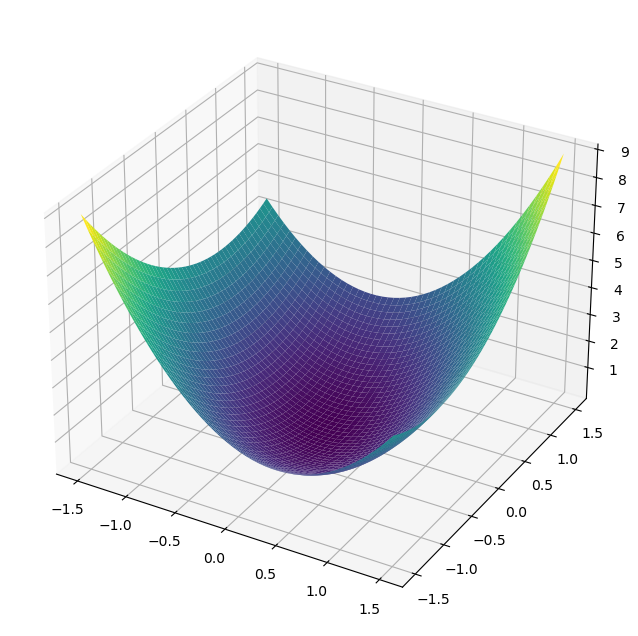

In [275]:
x_3d, y_3d, z_3d = setup_3d_data(f_1, 50)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x_3d, y_3d, z_3d, cmap=plt.cm.viridis, antialiased=True)

plt.show()


#### Сходимость градиентного спуска с постоянным шагом


In [276]:
steps = np.array([0.1, 0.01, 0.001, 0.0001])
grad_methods = []
for i in range(len(steps)):
    grad_method = gradient_descent(f_1, f_1_grad, np.ones(2), 0.0001, 0.0001, 50000, steps[i])
    grad_methods.append(grad_method)

,Шаг,Результат,Количество итераций
0,0.1000,"[-0.0001744813247185997, 0.0004212353263133035]",41
1,0.0100,"[-0.002353234431937529, 0.005692261940508953]",280
2,0.0010,"[-0.020930612977856148, 0.05878114897863999]",1362
3,0.0001,"[0.0816499624382001, 0.3340814588376377]",4214


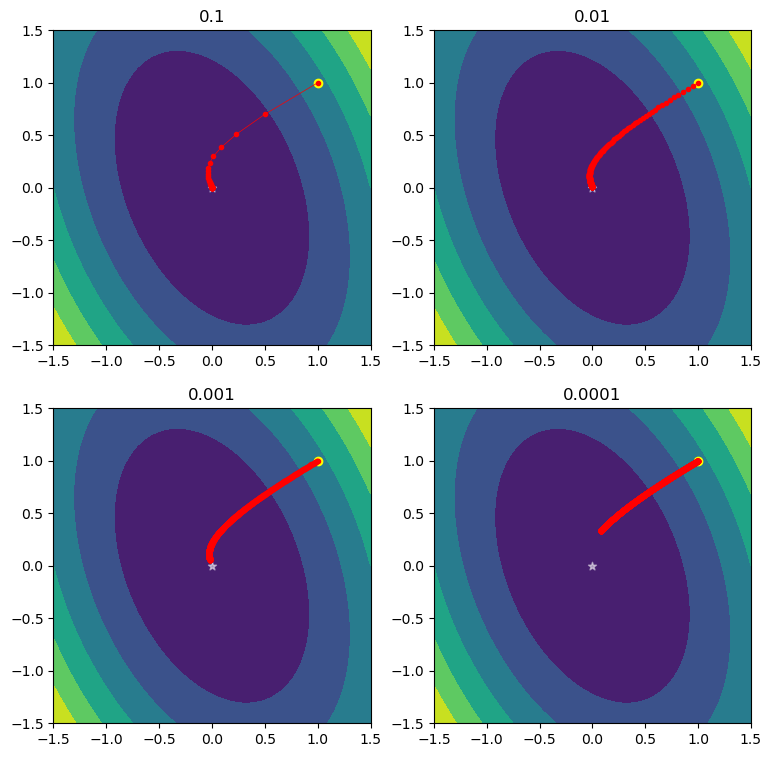

In [277]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
axs = np.ravel(axs)
df_f1 = pd.DataFrame({'Шаг':[], 'Результат':[], 'Количество итераций':[]})
for i in range(len(steps)):
    df_f1.loc[len(df_f1.index)] = [steps[i], grad_methods[i][2]['x'].iat[-1], grad_methods[i][1]]
    df_f1_x = grad_methods[i][2]
    x, y = np.split(np.array(df_f1_x.x.values.tolist()), 2, axis=1)

    axs[i].contourf(x_3d, y_3d, z_3d)
    axs[i].set_title(steps[i])
    axs[i].set_xlim(-1.5, 1.5)
    axs[i].set_ylim(-1.5, 1.5)
    axs[i].plot(x, y, color='red', marker='.', linewidth=0.5)
    axs[i].scatter(x[0], y[0], color='yellow', marker='o')
    axs[i].scatter(0, 0, color='white', marker='*', alpha=0.5)
df_f1


#### Работа методов


,Метод,Результат,Количество итераций
0,Спуск с постоянным шагом,"[-0.0018752265188603091, 0.004527299451519817]",29
1,Спуск с дроблением шага,"[-0.00039534270763397217, 0.0009544417262077332]",13
2,Наискорейший спуск,"[-0.0001324877938975228, 0.00024014786376353532]",7
3,Сопряженных градиентов,"[-7.924663179892377e-06, -6.345182063216548e-06]",2


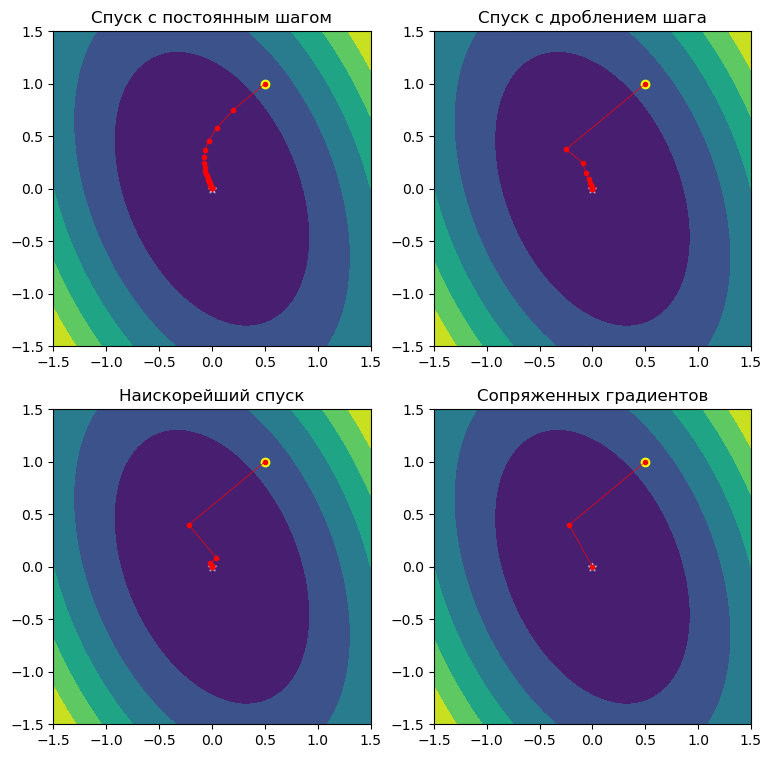

In [278]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
methods = [gradient_descent, step_splitting_descent, steepest_descent, conjugate_gradient]
names = ['Спуск с постоянным шагом', 'Спуск с дроблением шага', 'Наискорейший спуск', 'Сопряженных градиентов']
axs = np.ravel(axs)
df_f1 = pd.DataFrame({'Метод':[], 'Результат':[], 'Количество итераций':[]})
for i in range(len(axs)):
    data_all = methods[i](f_1, f_1_grad, np.array([0.5, 1]), 0.001, 0.001, 10000, 0.1)
    df_f1.loc[len(df_f1.index)] = [names[i], data_all[2]['x'].iat[-1], data_all[1]]
    data = data_all[2]
    x, y = np.split(np.array(data.x.values.tolist()), 2, axis=1)

    axs[i].contourf(x_3d, y_3d, z_3d)
    axs[i].set_title(names[i])
    axs[i].plot(x, y, color='red', marker='.', linewidth=0.5)
    axs[i].scatter(x[0], y[0], color='yellow', marker='o')
    axs[i].scatter(0, 0, color='white', marker='*', alpha=0.5)
df_f1


#### Работа при изменении начальной точки


,Метод,Результат,Количество итераций
0,Спуск с постоянным шагом,"[0.0020212515942434834, -0.004879730020845609]",31
1,Спуск с дроблением шага,"[-0.0005502700805664062, 0.0013284683227539062]",11
2,Наискорейший спуск,"[-0.00014377760885522848, -0.00017969777764366...",5
3,Сопряженных градиентов,"[-1.3490060534332438e-06, 2.0092862682702384e-06]",2


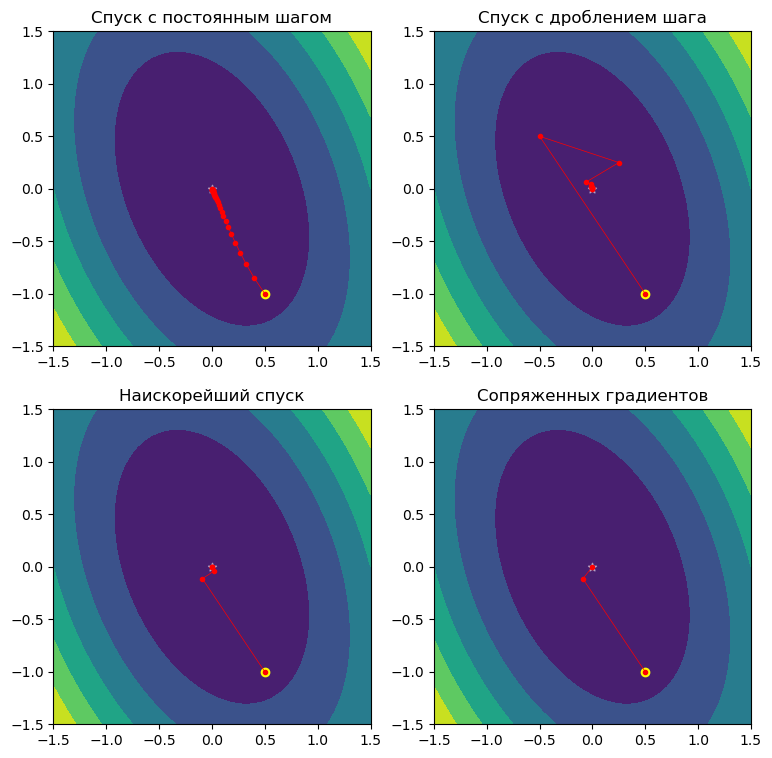

In [279]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
methods = [gradient_descent, step_splitting_descent, steepest_descent, conjugate_gradient]
names = ['Спуск с постоянным шагом', 'Спуск с дроблением шага', 'Наискорейший спуск', 'Сопряженных градиентов']
axs = np.ravel(axs)
df_f1 = pd.DataFrame({'Метод':[], 'Результат':[], 'Количество итераций':[]})
for i in range(len(axs)):
    data_all = methods[i](f_1, f_1_grad, np.array([0.5, -1]), 0.001, 0.001, 10000, 0.1)
    df_f1.loc[len(df_f1.index)] = [names[i], data_all[2]['x'].iat[-1], data_all[1]]
    data = data_all[2]
    x, y = np.split(np.array(data.x.values.tolist()), 2, axis=1)

    axs[i].contourf(x_3d, y_3d, z_3d)
    axs[i].set_title(names[i])
    axs[i].plot(x, y, color='red', marker='.', linewidth=0.5)
    axs[i].scatter(x[0], y[0], color='yellow', marker='o')
    axs[i].scatter(0, 0, color='white', marker='*', alpha=0.5)
df_f1


### $f_2(x)$


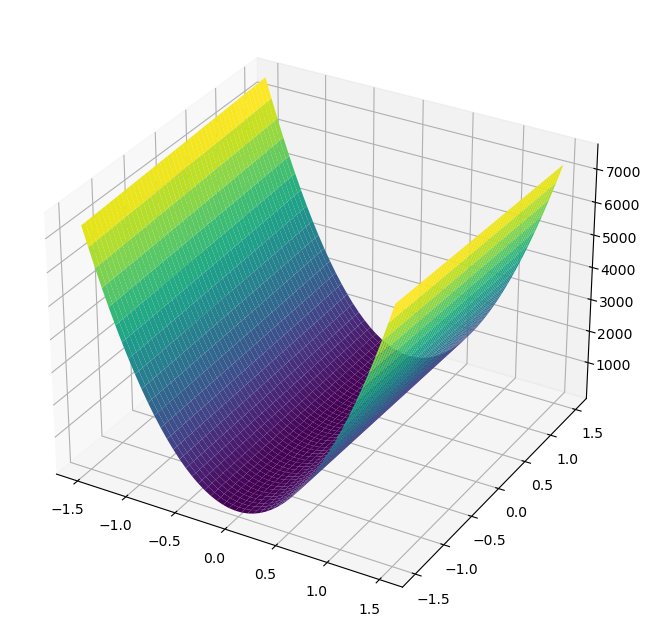

In [280]:
x_3d, y_3d, z_3d = setup_3d_data(f_2, 50)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(x_3d, y_3d, z_3d, cmap=plt.cm.viridis, antialiased=True)

plt.show()


#### Сходимость градиентного спуска с постоянным шагом


In [281]:
steps = np.array([0.00005, 0.0002, 0.0003, 0.0004])
grad_methods = []
for i in range(len(steps)):
    grad_method = gradient_descent(f_2, f_2_grad, np.ones(2), 0.0001, 0.0001, 20000, steps[i])
    grad_methods.append(grad_method)

C:\Users\moroz\AppData\Local\Temp\ipykernel_37428\4024579487.py:6: RuntimeWarning: overflow encountered in matmul
  return (a + a.T) @ x.T
C:\Users\moroz\AppData\Local\Temp\ipykernel_37428\3004584660.py:14: RuntimeWarning: invalid value encountered in subtract
  x_next = x - t * grad_x


,Шаг,Результат,Количество итераций
0,0.00005,"[0.0077943784397011134, 0.7069645173858351]",3576
1,0.00020,"[0.0027542372374349815, 0.24981440334118335]",3494
2,0.00030,"[0.0018357971829869033, 0.16651019443423132]",3005
3,0.00040,"[nan, -inf]",1420


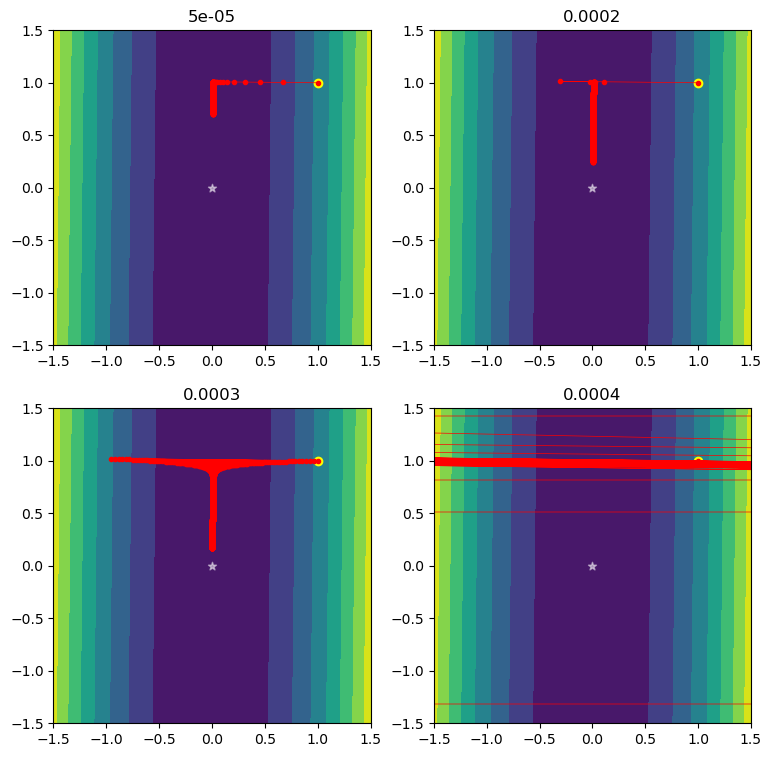

In [282]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
axs = np.ravel(axs)
df_f2 = pd.DataFrame({'Шаг':[], 'Результат':[], 'Количество итераций':[]})
for i in range(len(steps)):
    df_f2.loc[len(df_f2.index)] = [steps[i], grad_methods[i][2]['x'].iat[-1], grad_methods[i][1]]
    df_f2_x = grad_methods[i][2]
    x, y = np.split(np.array(df_f2_x.x.values.tolist()), 2, axis=1)

    axs[i].contourf(x_3d, y_3d, z_3d)
    axs[i].set_title(steps[i])
    axs[i].set_xlim(-1.5, 1.5)
    axs[i].set_ylim(-1.5, 1.5)
    axs[i].plot(x, y, color='red', marker='.', linewidth=0.5)
    axs[i].scatter(x[0], y[0], color='yellow', marker='o')
    axs[i].scatter(0, 0, color='white', marker='*', alpha=0.5)
df_f2


#### Работа методов


,Метод,Результат,Количество итераций
0,Спуск с постоянным шагом,"[0.0002754577256551792, 0.02498452437029489]",9249
1,Спуск с дроблением шага,"[0.00022562993768827054, 0.020465051990945022]",7985
2,Наискорейший спуск,"[5.737881303882956e-05, 0.005183328063839246]",814
3,Сопряженных градиентов,"[2.7340413514594096e-08, -4.549005564539075e-06]",10


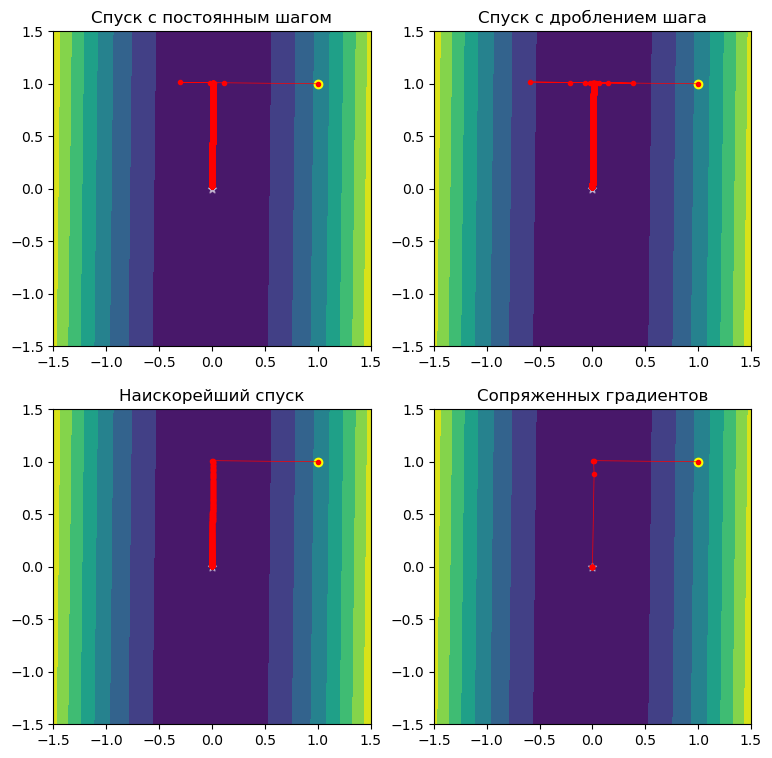

In [283]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
methods = [gradient_descent, step_splitting_descent, steepest_descent, conjugate_gradient]
names = ['Спуск с постоянным шагом', 'Спуск с дроблением шага', 'Наискорейший спуск', 'Сопряженных градиентов']
axs = np.ravel(axs)
df_f2 = pd.DataFrame({'Метод':[], 'Результат':[], 'Количество итераций':[]})
for i in range(len(axs)):
    data_all = methods[i](f_2, f_2_grad, np.ones(2), 0.00001, 0.00001, 10000, 0.0002)
    df_f2.loc[len(df_f2.index)] = [names[i], data_all[2]['x'].iat[-1], data_all[1]]
    data = data_all[2]
    x, y = np.split(np.array(data.x.values.tolist()), 2, axis=1)

    axs[i].contourf(x_3d, y_3d, z_3d)
    axs[i].set_title(names[i])
    axs[i].plot(x, y, color='red', marker='.', linewidth=0.5)
    axs[i].scatter(x[0], y[0], color='yellow', marker='o')
    axs[i].scatter(0, 0, color='white', marker='*', alpha=0.5)
df_f2


#### Работа при изменении начальной точки


,Метод,Результат,Количество итераций
0,Спуск с постоянным шагом,"[-0.00027543967957152963, -0.024982887557184422]",9219
1,Спуск с дроблением шага,"[-0.00022566200123346896, -0.02046796021370226]",7960
2,Наискорейший спуск,"[-0.00011517796104055683, -0.010560562952003496]",3526
3,Сопряженных градиентов,"[-8.774673683498247e-07, -7.618136513507304e-05]",10


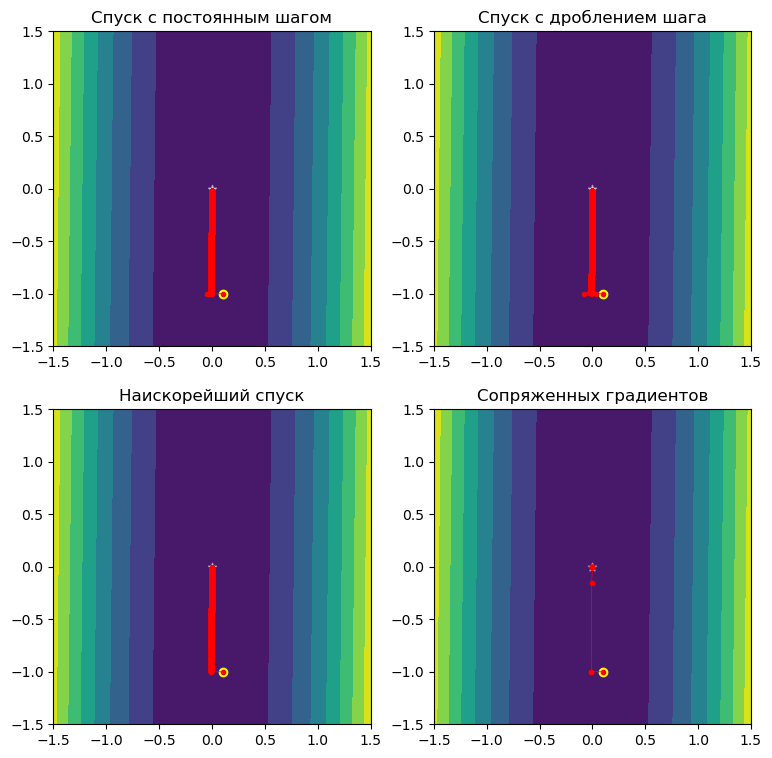

In [284]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
methods = [gradient_descent, step_splitting_descent, steepest_descent, conjugate_gradient]
names = ['Спуск с постоянным шагом', 'Спуск с дроблением шага', 'Наискорейший спуск', 'Сопряженных градиентов']
axs = np.ravel(axs)
df_f2 = pd.DataFrame({'Метод':[], 'Результат':[], 'Количество итераций':[]})
for i in range(len(axs)):
    data_all = methods[i](f_2, f_2_grad, np.array([0.1, -1]), 0.00001, 0.00001, 10000, 0.0002)
    df_f2.loc[len(df_f2.index)] = [names[i], data_all[2]['x'].iat[-1], data_all[1]]
    data = data_all[2]
    x, y = np.split(np.array(data.x.values.tolist()), 2, axis=1)

    axs[i].contourf(x_3d, y_3d, z_3d)
    axs[i].set_title(names[i])
    axs[i].plot(x, y, color='red', marker='.', linewidth=0.5)
    axs[i].scatter(x[0], y[0], color='yellow', marker='o')
    axs[i].scatter(0, 0, color='white', marker='*', alpha=0.5)
df_f2


## 7. Генератор функций


In [285]:
def f_gen(n, k):
    u, _ = np.linalg.qr(np.random.randn(n, n))
    d = np.diag(np.linspace(1, k, n))
    a = u @ d @ u.T
    return lambda x: x @ a @ x.T, lambda x: (a + a.T) @ x.T


## 8. Определение зависимости числа итераций $T$



### Зависимость $T$ от $n$ при $k = 5$ и от $k$ при $n = 5$


In [286]:
def t_all(n, k, method):
    res = []
    for i in range(len(n)):
        f, g = f_gen(n[i], k[i])
        x_0 = stats.uniform.rvs(size=n[i])
        res.append(method(f, g, x_0, 0.001, 0.001, 1000)[1])
    return np.array(res)

In [287]:
x_nk = y_nk = np.unique(np.geomspace(1, 1000, num=20, dtype=int))
res_n = t_all(x_nk, np.full(len(x_nk), 5), conjugate_gradient)
res_k = t_all(np.full(len(y_nk), 5), y_nk, conjugate_gradient)

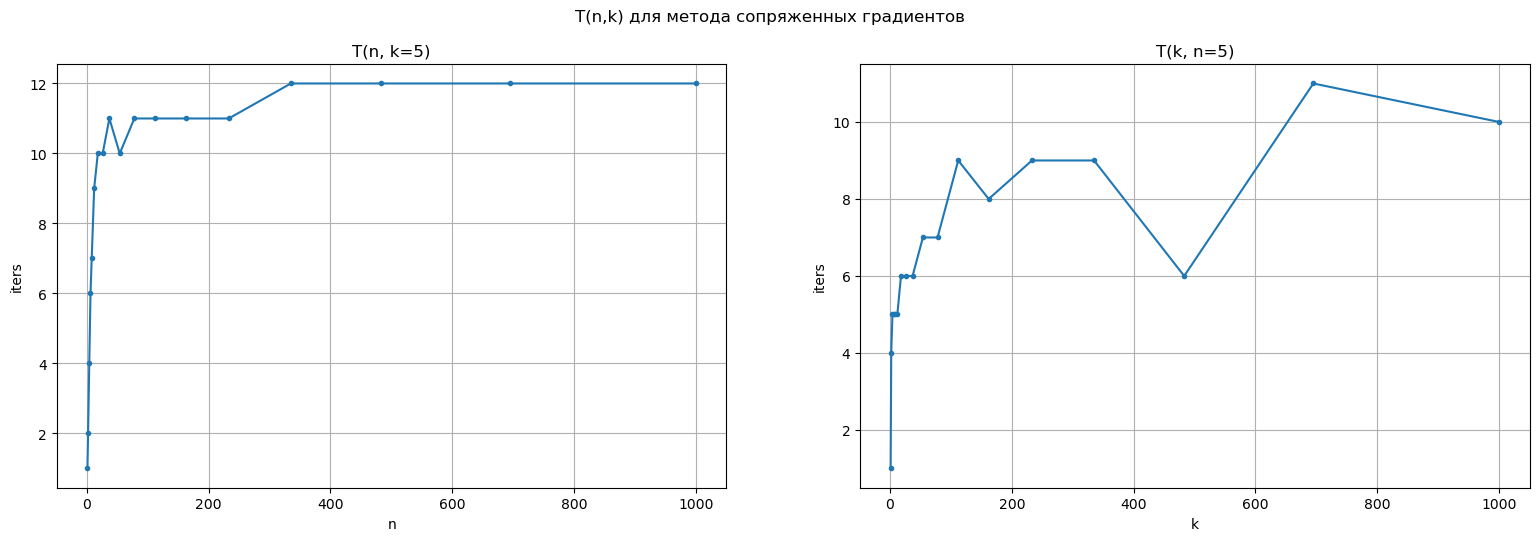

In [288]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(19, 5.5))
fig.suptitle('T(n,k) для метода сопряженных градиентов')

ax.grid()
ax.set_xlabel('n')
ax.set_ylabel('iters')
ax.set_title('T(n, k=5)')

ax1.grid()
ax1.set_xlabel('k')
ax1.set_ylabel('iters')
ax1.set_title('T(k, n=5)')

ax.plot(x_nk, res_n, marker='.')
ax1.plot(y_nk, res_k, marker='.')

plt.show()


### Зависимость $T$ от обоих параметров $n, k$

В силу технических ограничений, трехмерный график строится только для метода сопряженных градиентов

In [289]:
xp = yp = np.unique(np.geomspace(1, 1000, num=20, dtype=int))
n = len(xp)
xp1 = np.repeat(xp, n)
yp1 = np.tile(yp, n)
zp1 = t_all(xp1, yp1, conjugate_gradient)
x = np.reshape(xp1, (n, n))
y = np.reshape(yp1, (n, n))
z = np.reshape(zp1, (n, n))

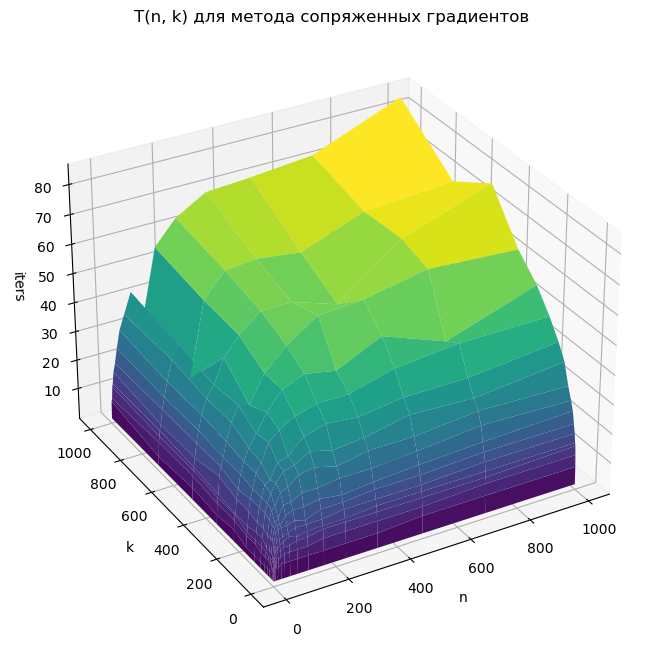

In [290]:
ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.plot_surface(x, y, z, cmap=plt.cm.viridis, antialiased=True)
ax.set_title('T(n, k) для метода сопряженных градиентов')
ax.set_xlabel('n')
ax.set_ylabel('k')
ax.set_zlabel('iters')
ax.view_init(30, -120)